# Evaluating A/B Test

After we have collected enough samples for the A/B test, here we will evaluate the result using statistical testing. The following is AB Testing to focus on the right media of advertisement. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

pd.options.display.max_columns = 999
pd.options.display.float_format = "{:.2f}".format

In [2]:
df = pd.read_csv('marketing_AB.csv')

df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
print(df['test group'].unique())

['ad' 'psa']


Data description:

* user_id: ID of the user
* group: user saw advertisement (group ad), user saw public service announcement (group psa) --> (control/variant)
* converted: bought the product (True), else is False
* total ads: amount of ads seen by this user
* most ads day: day that user saw highest amount/number of ads
* most ads hour: hour of day that person saw the highest amount of ads

In [4]:
df = df.drop(columns = ['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


1. Menentukan Objective A/B Testing
Tentukan tujuan utama dari pengujian A/B Testing berdasarkan dataset.
- Identifikasi metrik yang ingin diukur dalam pengujian.
- Pastikan objective spesifik dan dapat diuji dengan data.
- Jelaskan bagaimana pengujian ini dapat berdampak pada bisnis.
  
**Goals**: Memastikan pengujian memiliki tujuan yang jelas dan dapat diukur.

2. Menyusun Hipotesis
Buat hipotesis yang dapat diuji secara statistik berdasarkan dataset.
- Tentukan hipotesis alternatif (H1) dan hipotesis nol (H0).
- Pastikan hipotesis berhubungan langsung dengan metrik yang digunakan dalam dataset.
- Jelaskan bagaimana hasil pengujian akan menentukan penerimaan atau penolakan hipotesis.
  
**Goals**: Membantu student dalam menyusun hipotesis yang kuat dan objektif.

3. Merancang Desain Pengujian
Tentukan bagaimana pengujian akan dilakukan menggunakan dataset yang diberikan.
- Pembagian Grup:
    - Control Group: Pengguna yang tetap menggunakan fitur lama.
    - Target Group: Pengguna yang mendapatkan fitur baru.
- Sample Size: Berikan perkiraan jumlah sampel yang diperlukan.
- Randomization: Jelaskan bagaimana pengacakan akan dilakukan.
- Durasi: Tentukan durasi pengujian untuk mengumpulkan data yang cukup.
  
**Goals**: Merancang pengujian yang terstruktur dan bebas dari bias.

## Conversion Rate

First, we will evaluate if the conversion has increased with the new variant. To compare the proportion between two different samples, we can use the proportion z-test.

### Objectives

**Metric Choices**: 

      - Conversion rate: converted user/total user in that group
      - Average ads per user
      - Conversion rate by most ads hour or by most ads day
      - lift = conversion rate ad group/conversion rate psa group
  
    So choose both conversion rate and lift as metrics

**Objectives**: Test if ads can increase conversion incompare to PSA
**Business Impact**: 
1. If the test shows that ads are effective, company can increase the ads budget and optimize the marketing strategy for this media
2. If there is no significant difference, company can consider to decrease ads budget and focus on PSA or any other marketing strategies.

### Hypothesis

**$H_0$**: No difference of conversion between group who sees ads and group that sees PSA ($p_{ad} \leq p_{PSA}$)

**$H_1$**: There is a difference between ad group and PSA group ($p_{ad} > p_{PSA}$)

This is one direction hypothesis as we want to see the increase in conversion. This is called superiority test.

### Group division 

- **Control Group**: psa

- **Test (Variant) Group**: ad

- **Randomization**: User that is assigned randomly into one of the two groups (PSA or ads) so that there will be no systematic bias. We need to do this before _data collection_, so that two groups have similar basic characteristics like visitation, behavior, demography

- **Sample Size Estimate**: Estimating the minimum size of sample to detect a significant difference between tested metric such as ads total or conversion

- **Duration**: Duration is defined by daily traffic volume and time needed to achieve minimum sample size

### Proportion Z Test


Since the test is evaluating whether the variant is better than the control (superiority test), we need to adjust our hypothesis statement into the following:

$H_0: p_{variant} \leq p_{control}$

$H_1: p_{variant} > p_{control}$


In [5]:
from statsmodels.stats.proportion import proportions_ztest

group_psa = df[ df['test group'] == 'psa']
group_ad = df[ df['test group'] == 'ad']

conversion = [group_ad['converted'].sum(), group_psa['converted'].sum()]
sample = [group_ad.shape[0], group_psa.shape[0]]

conversion_rate_ad = df[df['test group'] == 'ad']['converted'].mean() # conversion[0]/sample[0]
conversion_rate_psa = df[df['test group'] == 'psa']['converted'].mean() # conversion[1]/sample[1]
lift = conversion_rate_ad/conversion_rate_psa

# Run one-sided two-proportion z-test (alternative: 'larger' means group_b > group_a)
z_stat, p_value = proportions_ztest(conversion, sample)

# Print results
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conversion Rate (ad): {conversion_rate_ad:.3%}")
print(f"Conversion Rate (psa): {conversion_rate_psa:.3%}")
print(f"Lift or ratio (conversion ad/psa): {lift}")

Z-statistic: 7.3701
P-value: 0.0000
Conversion Rate (ad): 2.555%
Conversion Rate (psa): 1.785%
Lift or ratio (conversion ad/psa): 1.4308506402222583


### Visualization

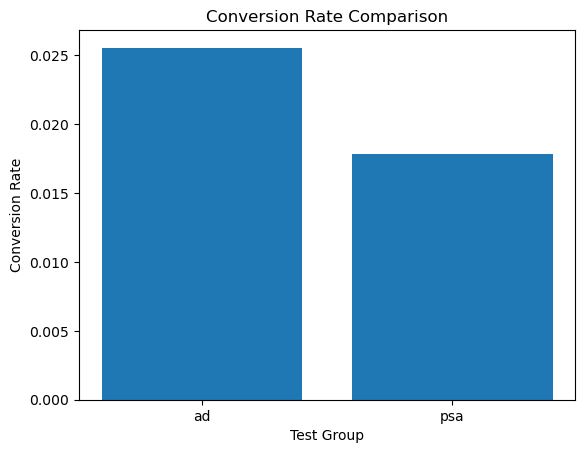

In [6]:
conversion_rates = [conversion_rate_ad, conversion_rate_psa]
groups = ['ad', 'psa']

plt.bar(groups, conversion_rates)
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate Comparison')
plt.show()

When the $H_0$ is rejected (p-value < 0.05), we can safely assume that the conversion rate of the variant is higher than the control group. We can also see the CVR variant (Ad) is 2.555% while CVR for control group (PSA) is 1.785%.

We can see that ads have big influence on conversion in comparison to PSA

In [7]:
df.columns

Index(['user id', 'test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

## Guardrail Metric: Total Ads

### Objectives

__Metrics__: Total ads shown to users of ad group in comparison to PSA group
__Objectives__: This test purpose is to evaluate whether the user in ads group see more advert in comparison to PSA group. This is to increase the effective advertisement distribution.

__Business Impact__:
1. If user in ad group see more adverts, the strategy is effective and should be continued
2. If not, company can review the policy and advert budget.

### Hypothesis

**$H_0$**: Total ads in ad group is less than PSA ($\mu_{ads} \leq \mu_{psa}$)

**$H_1$**: Total ads in ad group is more than PSA ($\mu_{ads} > \mu_{psa}$)

One tailed hypothesis test (right tailed or left tailed) is to check whether this ad group received significantly different advertisement exposure in comparison to PSA group

### Group division 

- **Control Group**: psa

- **Test Group**: ad

- **Randomization**: User that is assigned randomly into one of the two groups (PSA or ads) so that there will be no systematic bias. We need to do this before _data collection_, so that two groups have similar basic characteristics like visitation, behavior, demography

- **Sample Size Estimate**: Estimating the minimum size of sample to detect a significant difference between tested metric such as ads total or conversion

- **Duration**: Duration is defined by daily traffic volume and time needed to achieve minimum sample size

In [8]:
from scipy import stats

total_psa = df[df['test group'] == 'psa']['total ads'] # control
total_ad = df[df['test group'] == 'ad']['total ads'] # variant

# Normality Test (test if the dataset follow normal distribution)
def ad_normal_test(x):
    # Perform the Anderson-Darling test
    result = stats.anderson(x, dist='norm')

    # Interpretation
    for cv, sig in zip(result.critical_values[2:], result.significance_level[2:]):
        if result.statistic < cv:
            print(f"Fail to reject normality at {sig}% significance level")
        else:
            print(f"Reject normality at {sig}% significance level")
    return ''

print('Ad:')
print(ad_normal_test(total_ad))

print('PSA:')
print(ad_normal_test(total_psa))

Ad:
Reject normality at 5.0% significance level
Reject normality at 2.5% significance level
Reject normality at 1.0% significance level

PSA:
Reject normality at 5.0% significance level
Reject normality at 2.5% significance level
Reject normality at 1.0% significance level



In [9]:
t_stat, p_value = stats.ttest_ind(total_ad, total_psa, alternative='greater')

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Mean of total PSA: {total_psa.mean():.2f}")
print(f"Mean of total Ad: {total_ad.mean():.2f}")

T-statistic: 0.2139
P-value: 0.4153
Mean of total PSA: 24.76
Mean of total Ad: 24.82


p-value = 0.4153 $\gg$ 0.05, fail to reject $H_0$. It doesn't mean $H_0$ is true, it only means we don't have strong evidence to say $H_1$ is true.

no statistically significant evidence that users in the ad group saw more ads than the PSA group.

In [10]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(total_ad, total_psa, alternative='greater')

print("Mann-Whitney U test u-stat:", u_stat)
print("Mann-Whitney U test p-value:", p_value)
print(f"Mean of total PSA: {total_psa.mean():.2f}")
print(f"Mean of total Ad: {total_ad.mean():.2f}")

Mann-Whitney U test u-stat: 6808288222.0
Mann-Whitney U test p-value: 2.3454554273602847e-11
Mean of total PSA: 24.76
Mean of total Ad: 24.82


Mann-Whitney U test was used because the distribution of total ads in both groups did not follow normality, as indicated by the Anderson-Darling test. The test does not assume normal distribution and is robust to skewed or ordinal data.

Here p < 0.05, so we have to reject $H_0$ that claims total ads in ad group is less or equal than psa group and accept $H_1$. there's statistically significant evidence that the ad group saw more ads than the PSA group or $\mu_{ad} > \mu_{psa}$.

U-statistic counts how many times values in one group rank higher than the other. In large datasets, the U value is also large — but the raw U value is not important. What matters is the p-value derived from it.

Mean of Ad group: 24.82, while mean of PSA group: 24.76 and of course, p-value: ~2.3e-11. Therefore, ad group saw significantly more ads than PSA group according to p-value. But the difference in mean is only 0.06 ads, less than 1 ad per person. It’s statistically significant, but it may not matter in real business terms.

Given the large sample size (>580K users), even very small differences can yield statistically significant results. Hence, it's important to consider both p-value and effect size when drawing business conclusions.

In [11]:
# Sample smaller for faster computation if needed
sample_ad = total_ad.sample(5000, random_state=1)
sample_psa = total_psa.sample(5000, random_state=1)

# Compute Cliff's delta
diffs = [np.sign(x - y) for x, y in product(sample_ad, sample_psa)]
cliffs_delta = np.mean(diffs)
print("Cliff's Delta:", cliffs_delta)

Cliff's Delta: 0.00757412


**_However, the effect size is very small (Cliff’s Delta ≈ 0.007), suggesting that although the result is statistically significant, the actual difference is negligible in practical terms._**

In [12]:
# Compare avg ads seen
df.groupby('test group')['total ads'].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.00,24.82,43.75,1.00,4.00,13.00,27.00,2065.00
psa,23524.00,24.76,42.86,1.00,4.00,12.00,26.00,907.00


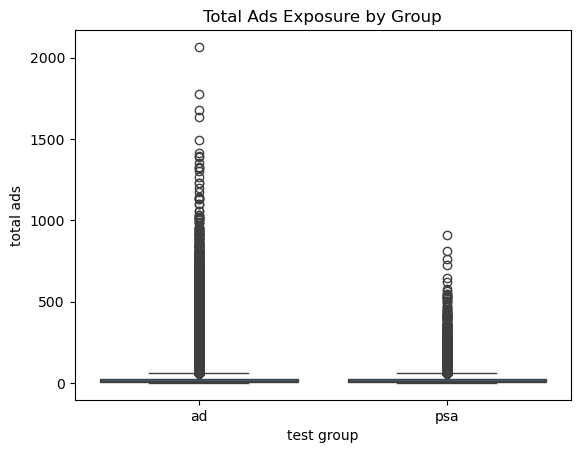

In [13]:
# Optional visualization
sns.boxplot(data=df, x='test group', y='total ads')
plt.title('Total Ads Exposure by Group')
plt.show()

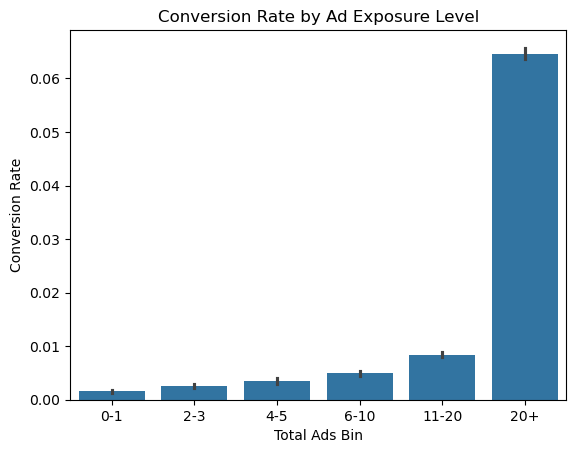

In [14]:
df['ads_bin'] = pd.cut(df['total ads'], bins=[0, 1, 3, 5, 10, 20, df['total ads'].max()], 
                       labels=['0-1','2-3','4-5','6-10','11-20','20+'])
sns.barplot(x='ads_bin', y='converted', data=df)
plt.title('Conversion Rate by Ad Exposure Level')
plt.ylabel('Conversion Rate')
plt.xlabel('Total Ads Bin')
plt.show()

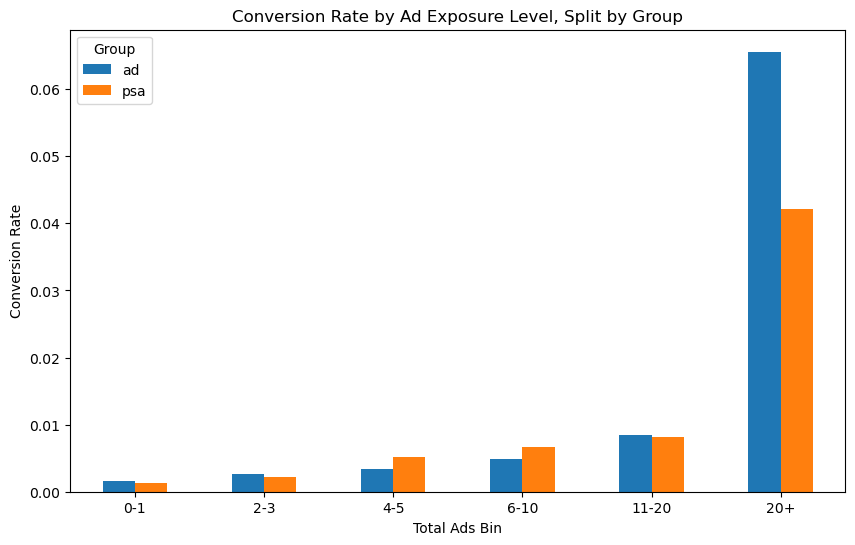

In [15]:
conversion_by_bin_group = df.groupby(['test group', 'ads_bin'], observed=True)['converted'].mean().unstack()
conversion_by_bin_group.T.plot(kind='bar', figsize=(10,6))
plt.title('Conversion Rate by Ad Exposure Level, Split by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Total Ads Bin')
plt.legend(title='Group')
plt.xticks(rotation=0)
plt.show()

In [16]:
df.groupby(['test group', 'ads_bin'], observed=True)['converted'].agg(['mean', 'count'])

mean   count
test group ads_bin              
ad         0-1      0.00   54298
           2-3      0.00   65239
           4-5      0.00   50425
           6-10     0.00   79537
           11-20    0.01  123334
           20+      0.07  191744
psa        0-1      0.00    2308
           2-3      0.00    3249
           4-5      0.01    2304
           6-10     0.01    3415
           11-20    0.01    4150
           20+      0.04    8098

_**If we are to discuss most ads hour and most ads day, we're no longer doing A/B testing since this is segmentation**_

In [17]:
from scipy.stats import chi2_contingency

# Buat tabulasi kontingensi
hour_ct = pd.crosstab(df['most ads hour'], df['converted'])

# Uji chi-square
chi2, p, dof, expected = chi2_contingency(hour_ct)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.4f}")

Chi-square: 430.77, p-value: 0.0000


In [18]:
# Buat tabulasi kontingensi
day_ct = pd.crosstab(df['most ads day'], df['converted'])

# Uji chi-square
chi2_day, p_day, dof_day, expected_day = chi2_contingency(day_ct)
print(f"Chi-square: {chi2_day:.2f}, p-value: {p_day:.4f}")

Chi-square: 410.05, p-value: 0.0000


**There is a significant difference between different day and hour for conversion rate**

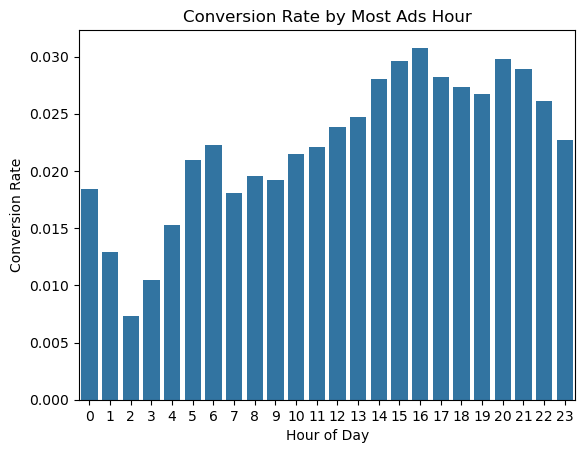

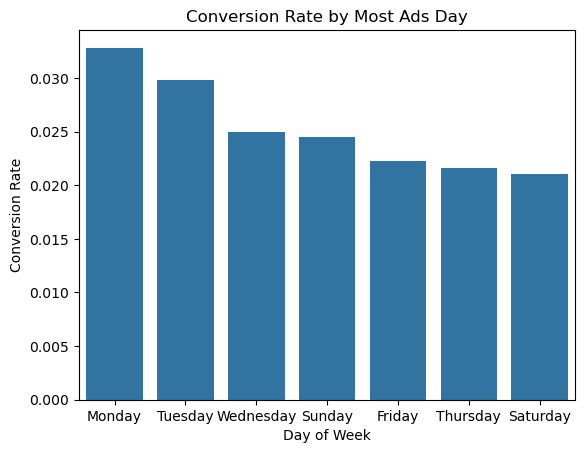

In [19]:
# Conversion rate by most_ads_hour
hourly_conversion = df.groupby('most ads hour')['converted'].mean().sort_values(ascending=False)
sns.barplot(x=hourly_conversion.index, y=hourly_conversion.values)
plt.title('Conversion Rate by Most Ads Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Conversion Rate')
plt.show()

# Conversion rate by most_ads_day
day_conversion = df.groupby('most ads day')['converted'].mean().sort_values(ascending=False)
sns.barplot(x=day_conversion.index, y=day_conversion.values)
plt.title('Conversion Rate by Most Ads Day')
plt.xlabel('Day of Week')
plt.ylabel('Conversion Rate')
plt.show()

_**Day with highest conversion rate: Monday**_

_**Hour with highest conversion rate: 16th hour (16:00)**_